In [ ]:
!pip uninstall -y fbprophet
!pip uninstall -y pystan
!pip install Cython numpy pandas matplotlib LunarCalendar convertdate holidays setuptools-git python-dateutil tqdm
!pip install pystan==3.2.0  # Versão compatível
!pip install git+https://github.com/facebook/prophet.git@v0.7.1#egg=fbprophet

  Using cached pystan-3.2.0-py3-none-any.whl (13 kB)
INFO: pip is looking at multiple versions of pystan to determine which version is compatible with other requirements. This could take a while.
ERROR: Could not find a version that satisfies the requirement httpstan<4.6,>=4.5 (from pystan) (from versions: 4.6.1, 4.7.0, 4.7.1, 4.7.2, 4.8.0, 4.8.1, 4.8.2, 4.9.0, 4.9.1, 4.10.0, 4.10.1, 4.11.0, 4.12.0)
ERROR: No matching distribution found for httpstan<4.6,>=4.5
  Cloning https://github.com/facebook/prophet.git (to revision v0.7.1) to /tmp/pip-install-yiyx7ssp/fbprophet_354612e0ac3e4cf88af2016f0e462a72
  Running command git clone --filter=blob:none --quiet https://github.com/facebook/prophet.git /tmp/pip-install-yiyx7ssp/fbprophet_354612e0ac3e4cf88af2016f0e462a72
  Running command git checkout -q v0.7.1
  error: pathspec 'v0.7.1' did not match any file(s) known to git
  error: subprocess-exited-with-error
  
  × git checkout -q v0.7.1 did not run successfully.
  │ exit code: 1
  ╰─> See a

In [ ]:
# Bibliotecas básicas de data science
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
%matplotlib inline

# Para baixar os dados
import yfinance as yf


#Para aplicar o ARIMA:
from statsmodels.tsa.stattools import adfuller          #verificar dados estacionários
from statsmodels.tsa.stattools import acf, pacf         #correlação
from statsmodels.tsa.seasonal import seasonal_decompose #Decomposição sazonal usando médias móveis.
from statsmodels.tsa.arima.model import ARIMA           #algoritmo arima

# Para deep learning
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout
from tensorflow.keras.optimizers import Adam
from keras.models import load_model
from keras.preprocessing.sequence import TimeseriesGenerator

# Para machine learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

# Prophet
from prophet import Prophet

#Upload do DataFrame

In [ ]:
import yfinance as yf

# Especifique o símbolo do Brent Crude Oil Last Day Financ (BZ=F) e o intervalo de datas desejado
symbol = 'BZ=F'

start_date = '1987-05-20' #data mais antiga do valor do IPEA (url providenciada no challenge)
end_date = '2024-05-20' #data escolhida para o final dos dados

# Use a função download para obter os dados
df = yf.download(symbol, start=start_date, end=end_date)

[*********************100%%**********************]  1 of 1 completed


In [ ]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2007-07-30,75.849998,76.529999,75.440002,75.739998,75.739998,2575
2007-07-31,75.699997,77.169998,75.669998,77.050003,77.050003,3513
2007-08-01,77.000000,77.059998,74.860001,75.349998,75.349998,3930
2007-08-02,75.220001,76.209999,74.269997,75.760002,75.760002,6180
2007-08-03,75.389999,76.000000,74.529999,74.750000,74.750000,4387
...,...,...,...,...,...,...
2024-05-08,83.040001,83.820000,81.720001,83.580002,83.580002,35419
2024-05-09,83.779999,84.330002,83.459999,83.879997,83.879997,25231
2024-05-10,84.209999,84.519997,82.709999,82.790001,82.790001,25062


In [ ]:
df_copy = df

In [ ]:
df = df.reset_index('Date')
df['Date'] = pd.to_datetime(df['Date']) #realizando a conversão da data para formato datetime
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2007-07-30,75.849998,76.529999,75.440002,75.739998,75.739998,2575
1,2007-07-31,75.699997,77.169998,75.669998,77.050003,77.050003,3513
2,2007-08-01,77.000000,77.059998,74.860001,75.349998,75.349998,3930
3,2007-08-02,75.220001,76.209999,74.269997,75.760002,75.760002,6180
4,2007-08-03,75.389999,76.000000,74.529999,74.750000,74.750000,4387


In [ ]:
df.shape #analisando linhas e colunas

(4169, 7)

In [ ]:
df_brent = df # criando cópia do dataset

### Visualizando os valores de fechamento

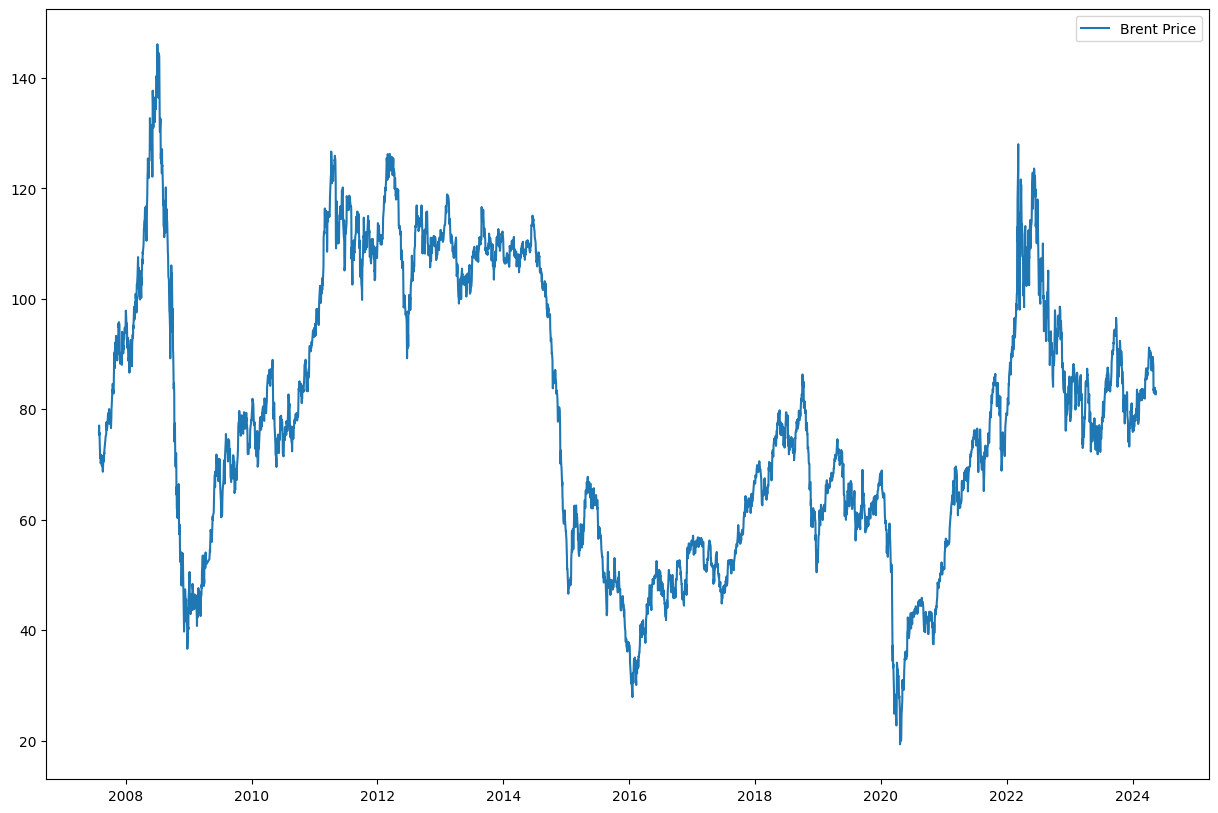

In [ ]:
plt.figure(figsize = (15,10))
plt.plot(df['Date'], df['Close'], label='Brent Price')

plt.legend(loc='best')
plt.show()

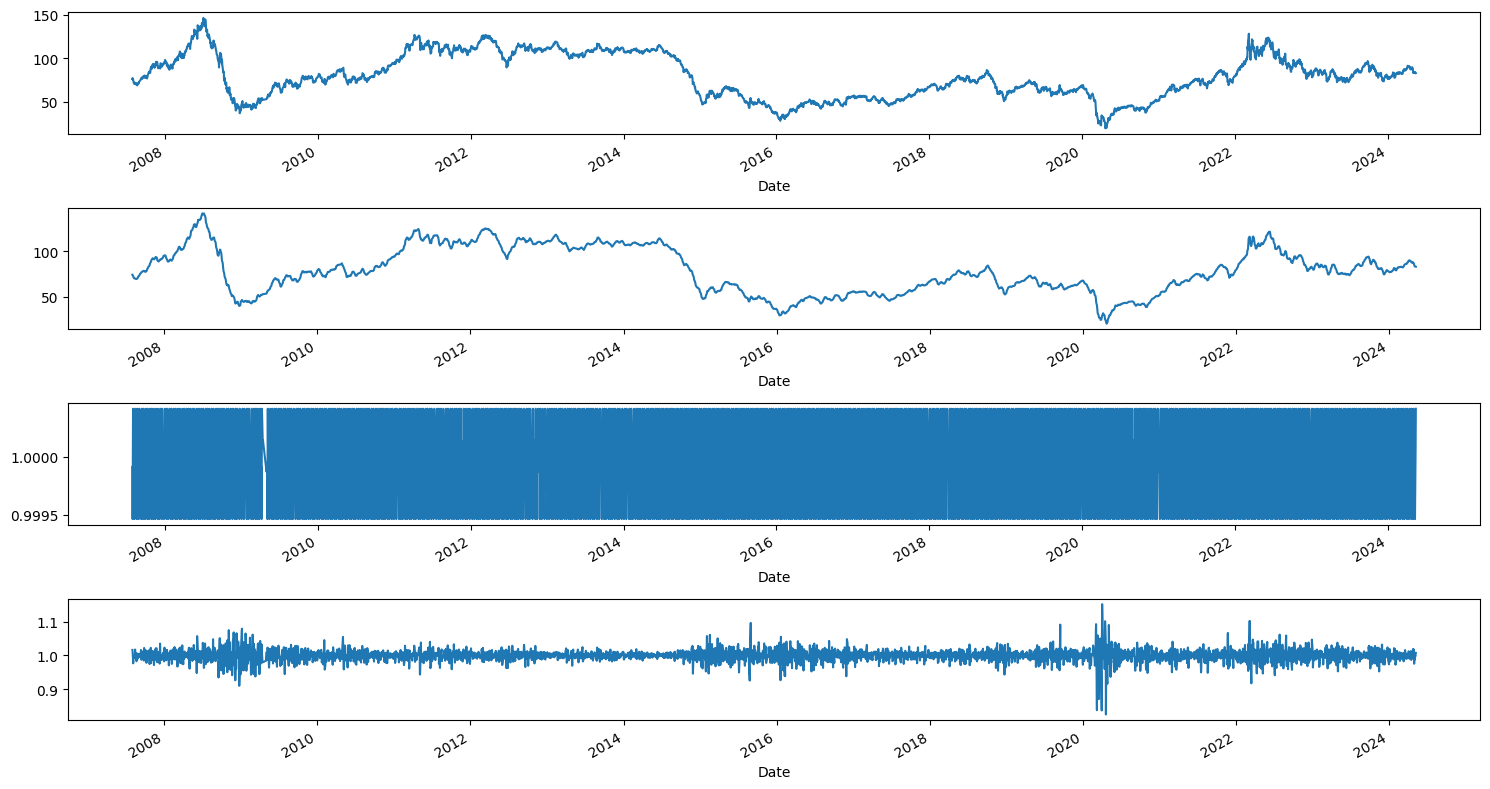

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

df_limpo = df                                                              # cópia do dataframe
df_limpo['Date'] = pd.to_datetime(df_limpo['Date'])                        # transformando em datetime
df_limpo = df.drop(columns=['Open', 'High', 'Low', 'Volume', 'Adj Close']) # Removendo colunas desnecessárias
df_limpo = df_limpo.set_index('Date')                                      # definindo data como índice

################################## Notas da análise de decomposição da série ########################################

# model='additive': Este parâmetro especifica o tipo de modelo utilizado na decomposição.

# Os dois tipos principais são:

# "additive" (modelo apropriado quando a magnitude da sazonalidade não varia com a tendência)
# "multiplicative" (modelo é mais apropriado quando a magnitude da sazonalidade varia com a tendência).

# period: Este é o período da sazonalidade. Ele especifica o número de observações em um ciclo sazonal.

######################################################################################################################

seasonplot = seasonal_decompose(df_limpo, model='multiplicative', period=7) #decopondo a série temporal
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15,8))
seasonplot.observed.plot(ax=ax1) #serie real
seasonplot.trend.plot(ax=ax2)    #tendencia
seasonplot.seasonal.plot(ax=ax3) #sazonalisade
seasonplot.resid.plot(ax=ax4)    #residuos
plt.tight_layout()

In [ ]:
df_limpo

,Close
Date,
2007-07-30,75.739998
2007-07-31,77.050003
2007-08-01,75.349998
2007-08-02,75.760002
2007-08-03,74.750000
...,...
2024-05-08,83.580002
2024-05-09,83.879997
2024-05-10,82.790001


In [ ]:
#Filtrando os dados
df = pd.DataFrame(df[['Close','Date']])
df.set_index('Date', inplace=True)

In [ ]:
df['MA_window_10'] = df['Close'].rolling(10).mean().shift() #média móvel em 10 dias
df['MA_window_20'] = df['Close'].rolling(20).mean().shift() #média móvel em 20 dias

#Rolling para deslocamento. Este parâmetro especifica o número de observações usadas para calcular a estatística
#shift é utilizado para deslocar o índice de DataFrame por um número especificado de períodos com uma freqüência de tempo opcional

In [ ]:
df.head(20)

,Close,MA_window_10,MA_window_20
Date,,,
2007-07-30,75.739998,NaN,NaN
2007-07-31,77.050003,NaN,NaN
2007-08-01,75.349998,NaN,NaN
2007-08-02,75.760002,NaN,NaN
2007-08-03,74.750000,NaN,NaN
2007-08-06,71.169998,NaN,NaN
2007-08-07,71.800003,NaN,NaN
2007-08-08,70.989998,NaN,NaN
2007-08-09,70.209999,NaN,NaN


### Visualizando o Resultado

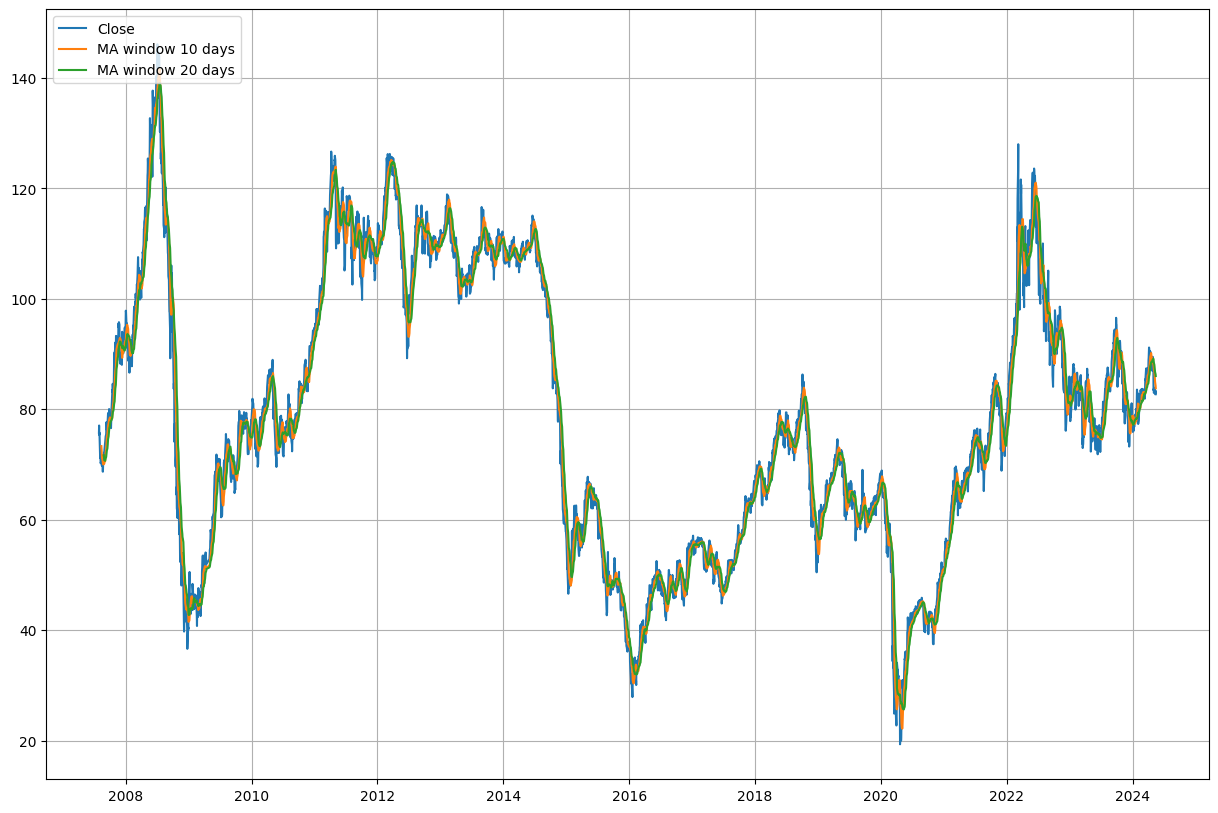

In [ ]:
plt.figure(figsize=(15,10))
plt.grid(True)
plt.plot(df['Close'], label='Close')
plt.plot(df['MA_window_10'], label='MA window 10 days')
plt.plot(df['MA_window_20'], label='MA window 20 days')
plt.legend(loc=2)
plt.show()

### Visualizando os dados mais recentes: últimos 300 dias

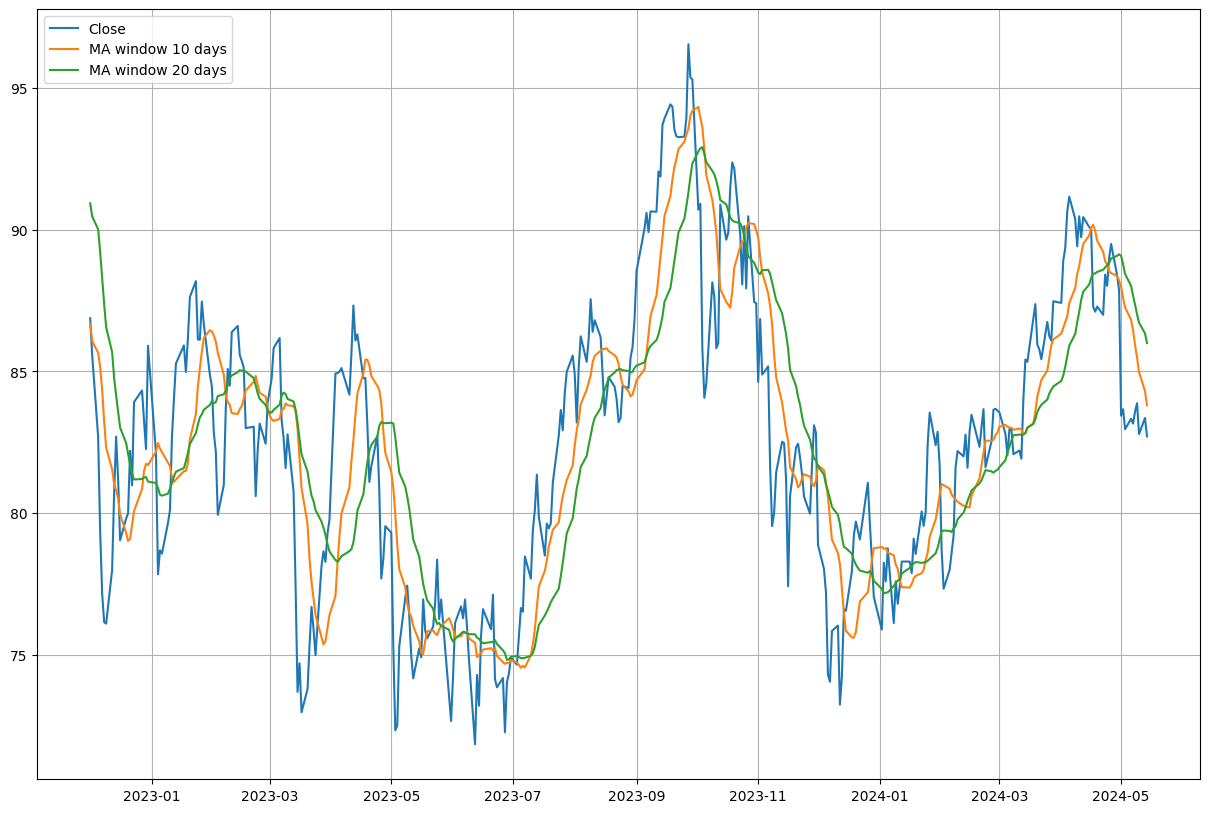

In [ ]:
limit = 365

plt.figure(figsize=(15,10))
plt.grid(True)
plt.plot(df['Close'][-limit:], label='Close')
plt.plot(df['MA_window_10'][-limit:], label='MA window 10 days')
plt.plot(df['MA_window_20'][-limit:], label='MA window 20 days')
plt.legend(loc=2)
plt.show()

### Prevendo os "N" dias com base na média móvel aritmética

In [ ]:
df['MA_window_10_forward_10'] = np.NaN #preechendo com NaN os valores da coluna de MA_window_10_forward_10

In [ ]:
def make_window(window_size, start_point):
    return [start_point+x for x in range(window_size)]  #realizando a janela de tempo

In [ ]:
window_size = 10
forward_days = 10

# Iteração sobre a série temporal com uma janela deslizante
for index in range(window_size, len(df), forward_days):

    # Iteração para calcular a média móvel ponderada
    for i in range(0, forward_days):
        # Verifica se o índice atual está dentro dos limites da série temporal
        if index + i >= len(df):
            break

        # Criando duas janelas:
        # 1. Uma janela para a média móvel ('window_close')
        # 2. Uma janela para a série temporal original ('window_MA')
        window_close = make_window(window_size - i, index + i - window_size)
        window_MA = make_window(i, index)

        # Calculando a média móvel ponderada
        mean = pd.concat([df['Close'].iloc[window_close], df['MA_window_10_forward_10'].iloc[window_MA]]).mean(axis=0)

        # Atualizando o DataFrame com a média móvel ponderada
        df.iat[index + i, df.columns.get_loc('MA_window_10_forward_10')] = mean


Plotando os dados

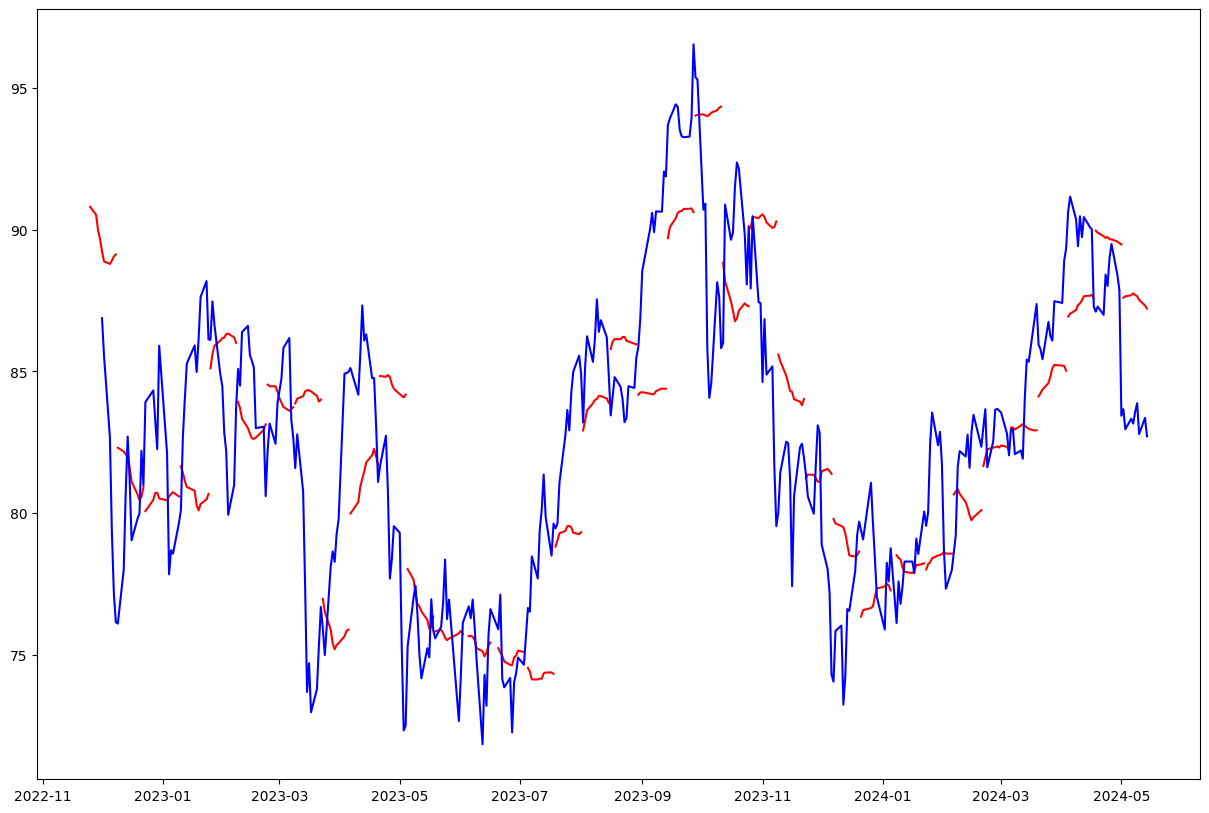

In [ ]:
plt.figure(figsize = (15,10))

size = len(df)-limit - (len(df)-limit)%forward_days

for index in range(size, len(df), forward_days):
    plt.plot(df['MA_window_10_forward_10'][index:index+forward_days], color='r')

plt.plot(df['Close'][-limit:], color='b', label='Close')
#plt.legend(loc='best')
plt.show()

Testando ARIMA

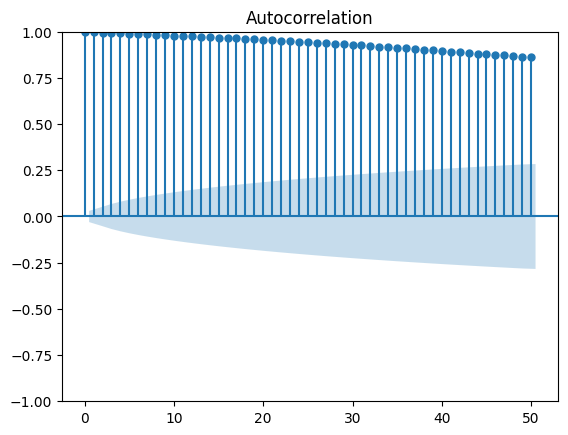

In [ ]:
import statsmodels.api as sm
sm.graphics.tsa.plot_acf(df_limpo, lags=50)
plt.show()

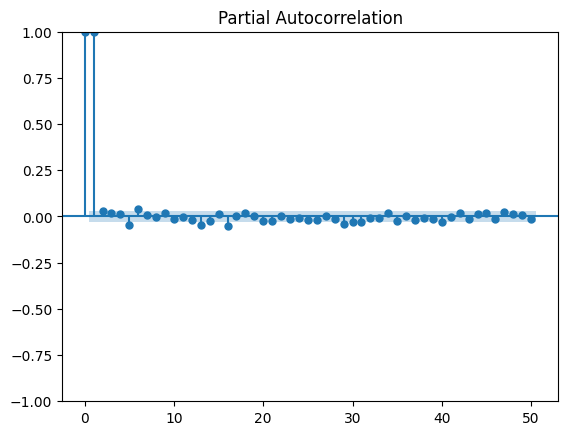

In [ ]:
sm.graphics.tsa.plot_pacf(df_limpo, lags=50)
plt.show()

In [ ]:
#Analisando Média Móvel e Desvio Padrão

rolmean = df_limpo.rolling(window=12).mean() #média móvel em 12 meses (dando a média móvel no nível anual).
rolstd = df_limpo.rolling(window=12).std()   #Desvio padrão em 12 meses
print(rolmean,rolstd)

                Close
Date                 
2007-07-30        NaN
2007-07-31        NaN
2007-08-01        NaN
2007-08-02        NaN
2007-08-03        NaN
...               ...
2024-05-08  85.945834
2024-05-09  85.567500
2024-05-10  85.131667
2024-05-13  84.660834
2024-05-14  84.095001

[4169 rows x 1 columns]                Close
Date                
2007-07-30       NaN
2007-07-31       NaN
2007-08-01       NaN
2007-08-02       NaN
2007-08-03       NaN
...              ...
2024-05-08  2.742034
2024-05-09  2.682177
2024-05-10  2.672336
2024-05-13  2.411945
2024-05-14  1.919718

[4169 rows x 1 columns]


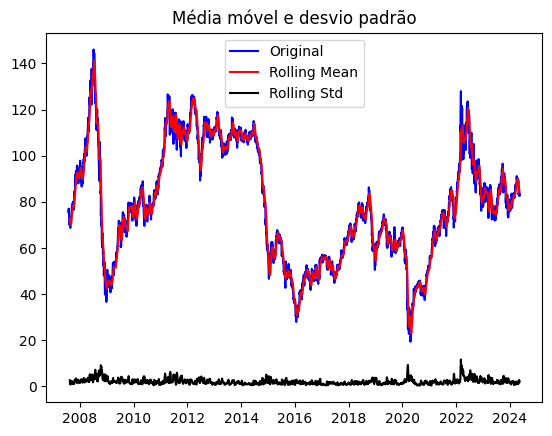

In [ ]:
#Plotando a média móvel
orig = plt.plot(df_limpo, color='blue', label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Média móvel e desvio padrão')
plt.show(block=False)

# Verificar estacionariedade da série temporal 📈

In [ ]:
from statsmodels.tsa.stattools import adfuller

# Teste de estacionariedade (ADF Test)
adf_result = adfuller(df_limpo['Close'])
print(f'ADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
print('Resultados do Teste de Estacionariedade:')
print('--------------------------------------')
print('Teste Estatístico:', adf_result[0])
print('Valor-p:', adf_result[1])
print('Valores Críticos:')
for key, value in adf_result[4].items():
    print(f'   {key}: {value}')

ADF Statistic: -2.296564091452905
p-value: 0.17307851516107492
Resultados do Teste de Estacionariedade:
--------------------------------------
Teste Estatístico: -2.296564091452905
Valor-p: 0.17307851516107492
Valores Críticos:
   1%: -3.431925571033693
   5%: -2.862236200776663
   10%: -2.5671405938787677


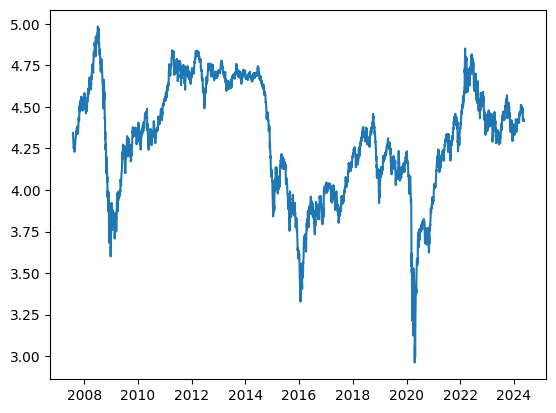

In [ ]:
#Estimating trend
indexedDataset_logScale = np.log(df_limpo) #Transformação logarítma
plt.plot(indexedDataset_logScale)

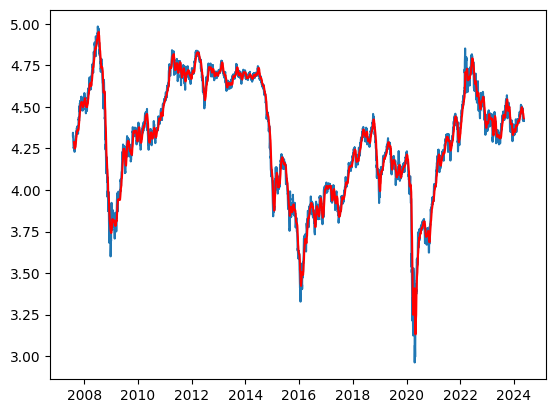

In [ ]:
# Calculando a média móvel
movingAverage = indexedDataset_logScale.rolling(window=12).mean()
movingSTD = indexedDataset_logScale.rolling(window=12).std()
plt.plot(indexedDataset_logScale)
plt.plot(movingAverage, color='red')

In [ ]:
datasetLogScaleMinusMovingAverage = indexedDataset_logScale - movingAverage
datasetLogScaleMinusMovingAverage.head(12)

#Remove NAN values
datasetLogScaleMinusMovingAverage.dropna(inplace=True)
datasetLogScaleMinusMovingAverage.head(10)

,Close
Date,
2007-08-14,-0.031761
2007-08-15,-0.011225
2007-08-16,-0.029403
2007-08-17,-0.014231
2007-08-20,-0.015874
2007-08-21,-0.025575
2007-08-22,-0.022486
2007-08-23,-0.003459
2007-08-24,0.007797


In [ ]:
# Função para testar a estacionariedade da série transformada

def test_stationarity(timeseries):

    #Determinar estatísticas contínuas
    movingAverage = timeseries.rolling(window=12).mean()
    movingSTD = timeseries.rolling(window=12).std()

    #Plot estatísticas contínuas
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(movingAverage, color='red', label='Rolling Mean')
    std = plt.plot(movingSTD, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Performance do Dickey–Fuller:
    print('Results of Dickey Fuller Test:')
    dftest = adfuller(timeseries['Close'], autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)


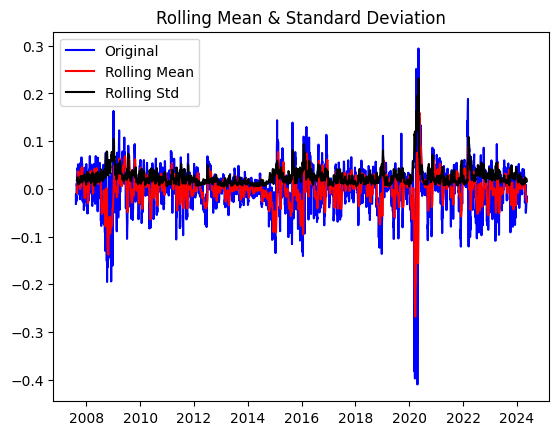

Results of Dickey Fuller Test:
Test Statistic                -1.004174e+01
p-value                        1.490075e-17
#Lags Used                     2.000000e+01
Number of Observations Used    4.137000e+03
Critical Value (1%)           -3.431932e+00
Critical Value (5%)           -2.862239e+00
Critical Value (10%)          -2.567142e+00
dtype: float64


In [ ]:
test_stationarity(datasetLogScaleMinusMovingAverage)

### 2º teste : Decaimento exponencial.



---



**Objetivo:** Remover a tendência de uma série temporal. A ideia básica é aplicar uma média exponencial ponderada aos dados, atribuindo mais peso às observações mais recentes e menos peso às observações mais antigas.


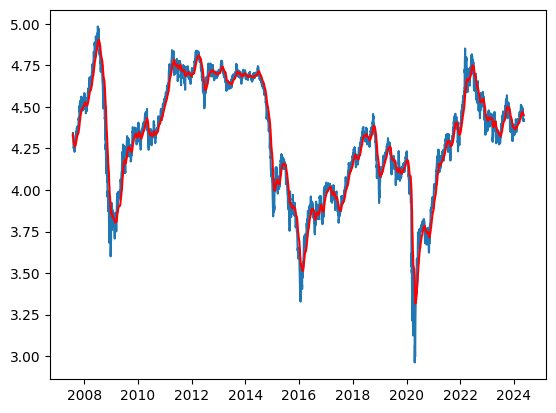

In [ ]:
exponentialDecayWeightedAverage = indexedDataset_logScale.ewm(halflife=12, min_periods=0, adjust=True).mean()
plt.plot(indexedDataset_logScale)
plt.plot(exponentialDecayWeightedAverage, color='red')

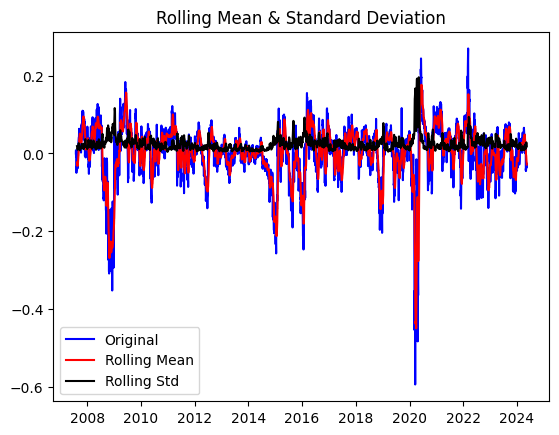

Results of Dickey Fuller Test:
Test Statistic                -7.708763e+00
p-value                        1.280473e-11
#Lags Used                     3.000000e+01
Number of Observations Used    4.138000e+03
Critical Value (1%)           -3.431931e+00
Critical Value (5%)           -2.862239e+00
Critical Value (10%)          -2.567142e+00
dtype: float64


In [ ]:
# Subtraindo o dataset em escala logarítma pelo decaimento exponencial
datasetLogScaleMinusExponentialMovingAverage = indexedDataset_logScale - exponentialDecayWeightedAverage
test_stationarity(datasetLogScaleMinusExponentialMovingAverage)

### 3º teste : Diferenciação



---



**Objetivo:** Remover a tendência e tornar a série mais estacionária.

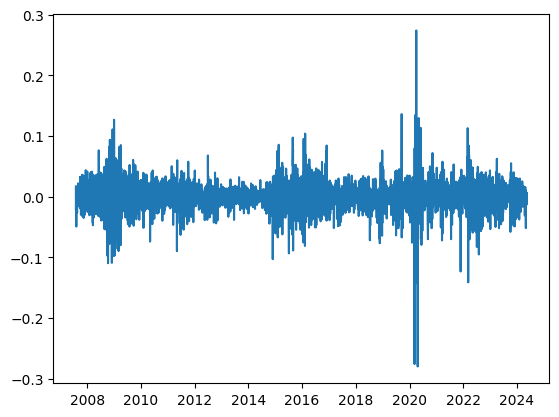

In [ ]:
datasetLogDiffShifting = indexedDataset_logScale - indexedDataset_logScale.shift() #diferença entre o valor anterior e o atual
plt.plot(datasetLogDiffShifting)

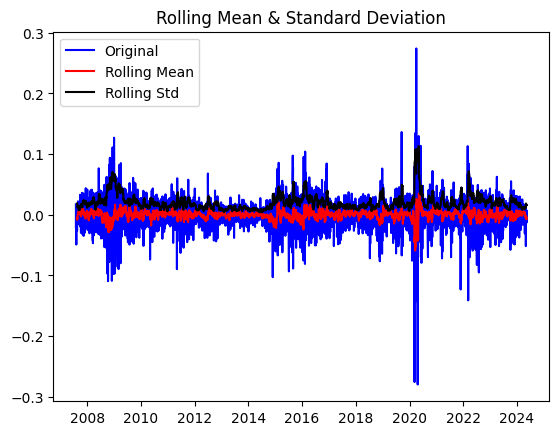

Results of Dickey Fuller Test:
Test Statistic                -9.546295e+00
p-value                        2.643802e-16
#Lags Used                     2.900000e+01
Number of Observations Used    4.138000e+03
Critical Value (1%)           -3.431931e+00
Critical Value (5%)           -2.862239e+00
Critical Value (10%)          -2.567142e+00
dtype: float64


In [ ]:
datasetLogDiffShifting.dropna(inplace=True)
test_stationarity(datasetLogDiffShifting)

# Teste de correlação parcial

Como definimos numa primeira tentativa o parâmetro **P (lags: valores auto correlacionados)** e o parâmetro **Q (tamanho de uma janela)** do ARIMA?

Vamos fazer isso com os **gráfico de ACF** (para ‘q’) e o **gráfico de PACF** (para ‘p’). Vamos selecionar como teste a base de dados da **diferenciação**.

Vamos encontrar em **qual ponto cada gráfico passa em zero e este ponto será o valor de P e Q inicial** (talvez em alguns casos pequenas alterações nos parâmetros do ARIMA possam melhorar/piorar os resultados, vale a pena alterar um pouco os valores um pouco positivamente e negativamente para olhar o desempenho).

Aplicando os plots ao nosso dataset de entrada (lags é o número de amostras):

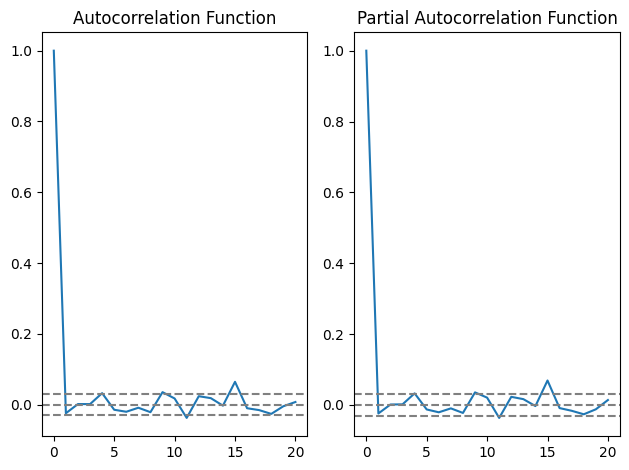

In [ ]:
#ACF & PACF plots

lag_acf = acf(datasetLogDiffShifting, nlags=20)
lag_pacf = pacf(datasetLogDiffShifting, nlags=20, method='ols')

#Plot ACF:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')

#Plot PACF
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(datasetLogDiffShifting)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')

plt.tight_layout()

Plotting AR model


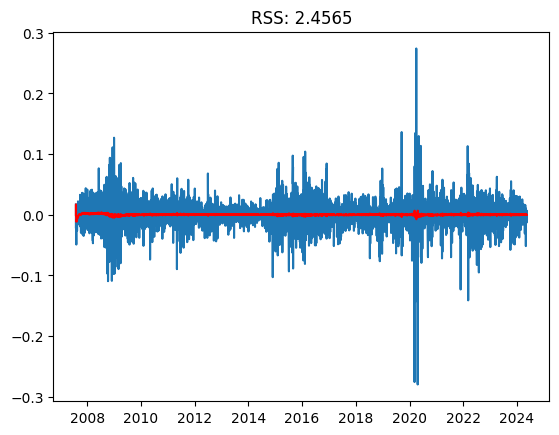

In [ ]:
#AR Model
model = ARIMA(datasetLogDiffShifting, order=(2,1,2))#(p,d,q)
results_AR = model.fit()
plt.plot(datasetLogDiffShifting)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RSS: %.4f'%sum((results_AR.fittedvalues - datasetLogDiffShifting['Close'])**2))
print('Plotting AR model')

**Validando o modelo com MAPE  (Mean Absolute Percentage Error)**

In [ ]:
from sklearn.metrics import mean_absolute_error

# Obtenha as previsões
predictions = results_AR.fittedvalues

# Ajuste os índices para garantir correspondência
predictions.index = datasetLogDiffShifting.index

# Inverta a diferenciação
# (indexedDataset_logScale['Close'].iloc[0]) para inverter a diferenciação.
# np.cumsum(predictions) é usado para calcular a soma cumulativa das previsões.
predicted_values = indexedDataset_logScale['Close'].iloc[0] + np.cumsum(predictions)

# Calcule o MAPE
mape = mean_absolute_error(datasetLogDiffShifting['Close'], predicted_values) * 100

print(f"MAPE: {mape:.2f}%")

MAPE: 469.27%


# Testando o modelo com prophet 🔮


In [ ]:
symbol = 'BZ=F'

start_date = '1987-05-20'
end_date = '2024-05-20'

# Use a função download para obter os dados
df = yf.download(symbol, start=start_date, end=end_date)
df = df.reset_index('Date')
df['Date'] = pd.to_datetime(df['Date']) #realizando a conversão da data para formato datetime
df.drop(columns=['Open', 'High', 'Low', 'Volume', 'Adj Close'], inplace=True)
df[['ds','y']] = df[['Date','Close']]
df.head()

df_copy = df

[*********************100%%**********************]  1 of 1 completed


In [ ]:
#Separando em Treino e Teste

train_data = df.sample(frac=0.8, random_state=0)
test_data = df.drop(train_data.index)
print(f'training data size : {train_data.shape}')
print(f'testing data size : {test_data.shape}')

training data size : (3335, 4)
testing data size : (834, 4)


In [ ]:
modelo = Prophet(daily_seasonality=True)
modelo.fit(train_data)
dataFramefuture = modelo.make_future_dataframe(periods=20, freq='M')
previsao = modelo.predict(dataFramefuture)
previsao.head()

DEBUG:cmdstanpy:input tempfile: /tmp/tmpfxfm4_c0/gk1wtyh5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfxfm4_c0/sj4c3nlh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=51524', 'data', 'file=/tmp/tmpfxfm4_c0/gk1wtyh5.json', 'init=/tmp/tmpfxfm4_c0/sj4c3nlh.json', 'output', 'file=/tmp/tmpfxfm4_c0/prophet_modelft3yjghq/prophet_model-20240514235907.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:59:08 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:59:09 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2007-07-31,77.760868,79.585166,108.135271,77.760868,77.760868,16.070022,16.070022,16.070022,12.794037,...,0.756016,0.756016,0.756016,2.519968,2.519968,2.519968,0.0,0.0,0.0,93.830890
1,2007-08-01,77.788095,79.257088,109.547715,77.788095,77.788095,16.032018,16.032018,16.032018,12.794037,...,0.828457,0.828457,0.828457,2.409524,2.409524,2.409524,0.0,0.0,0.0,93.820112
2,2007-08-03,77.842547,78.417085,107.209073,77.842547,77.842547,15.465905,15.465905,15.465905,12.794037,...,0.509534,0.509534,0.509534,2.162333,2.162333,2.162333,0.0,0.0,0.0,93.308452
3,2007-08-06,77.924226,77.732406,106.952945,77.924226,77.924226,14.664611,14.664611,14.664611,12.794037,...,0.129501,0.129501,0.129501,1.741073,1.741073,1.741073,0.0,0.0,0.0,92.588837
4,2007-08-07,77.951453,79.232758,107.546172,77.951453,77.951453,15.143234,15.143234,15.143234,12.794037,...,0.756016,0.756016,0.756016,1.593180,1.593180,1.593180,0.0,0.0,0.0,93.094686


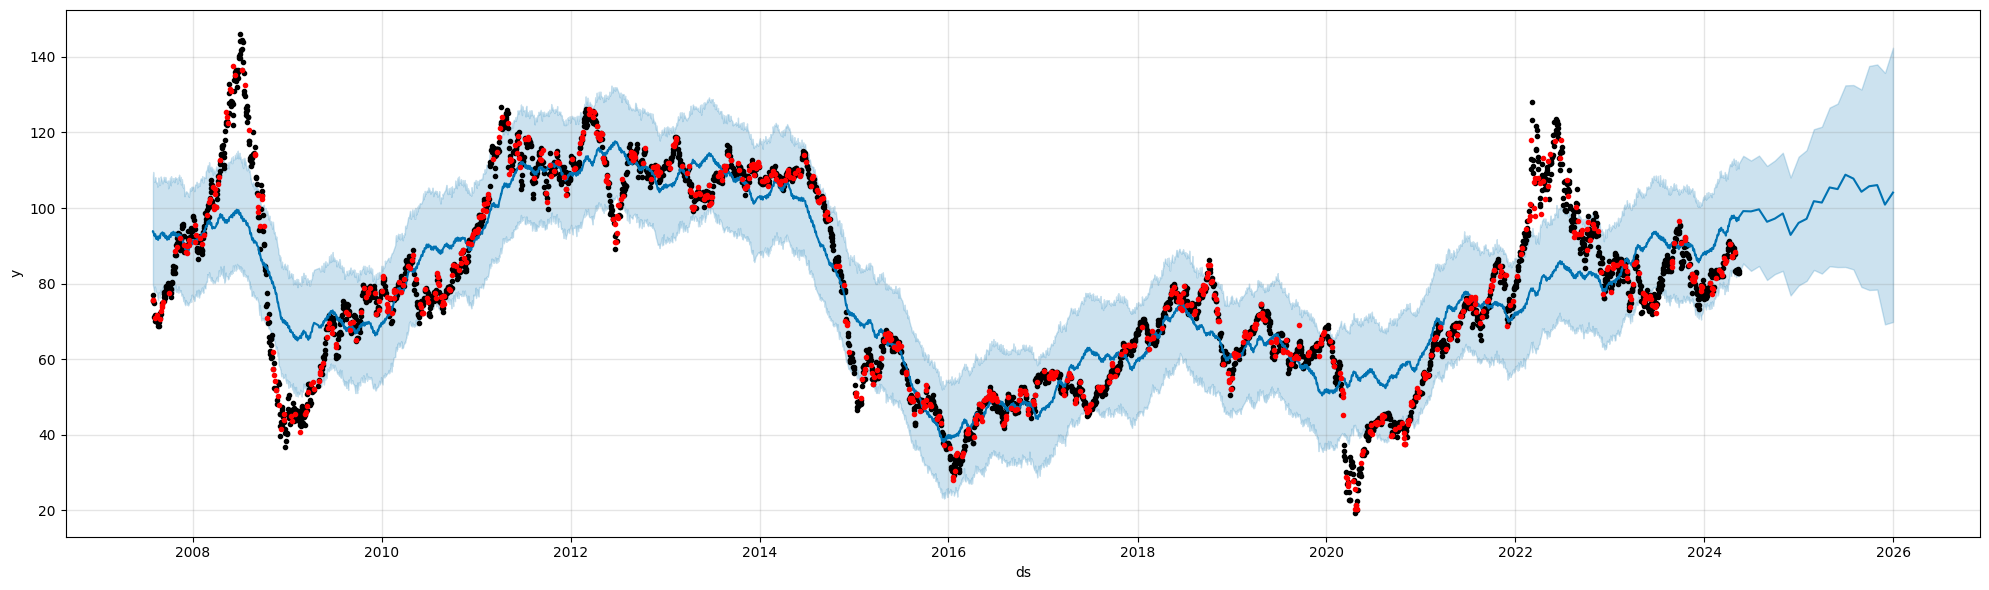

In [ ]:
modelo.plot(previsao, figsize=(20,6));
plt.plot(test_data['ds'], test_data['y'], '.r')

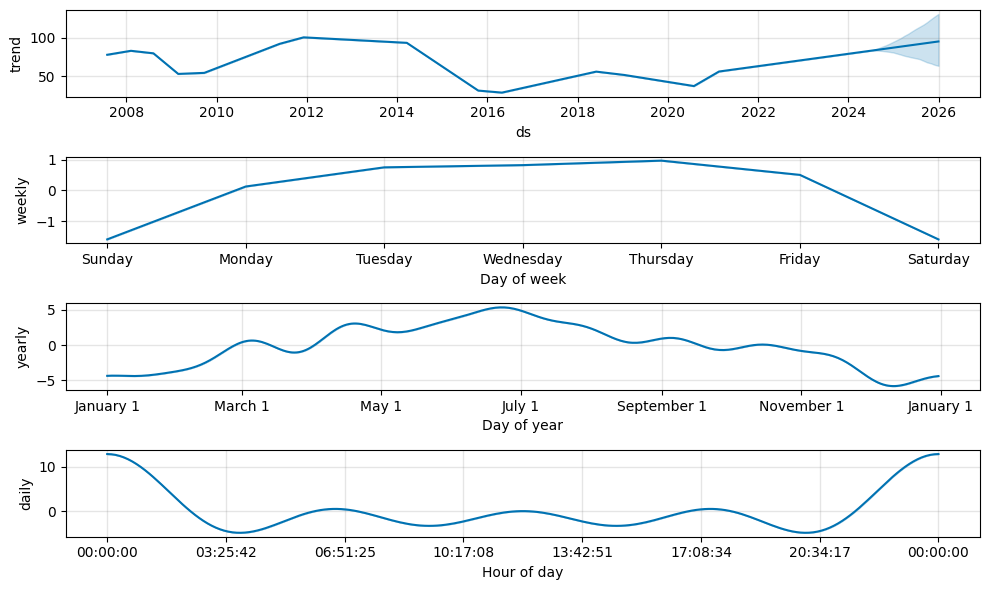

In [ ]:
modelo.plot_components(previsao, figsize=(10,6));

In [ ]:

# Extrair as colunas relevantes dos DataFrames
previsao_cols = ['ds', 'yhat']
valores_reais_cols = ['ds', 'y']

previsao = previsao[previsao_cols]
valores_reais = train_data[valores_reais_cols]

# Mesclar os DataFrames nas colunas 'ds' para comparar previsões e valores reais
resultados = pd.merge(previsao, valores_reais, on='ds', how='inner')

# Calcular o erro percentual absoluto para cada ponto de dados
resultados['erro_percentual_absoluto'] = np.abs((resultados['y'] - resultados['yhat']) / resultados['y']) * 100

# Calcular o MAPE
mape = np.mean(resultados['erro_percentual_absoluto'])

print(f"MAPE: {mape:.2f}%")

MAPE: 12.13%


In [ ]:
from prophet.diagnostics import cross_validation

df_cv = cross_validation(modelo, initial='730 days', period='180 days', horizon = '365 days')


INFO:prophet:Making 28 forecasts with cutoffs between 2010-01-23 00:00:00 and 2023-05-15 00:00:00


  0%|          | 0/28 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmpfxfm4_c0/al1r5_uc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfxfm4_c0/srpdj5ub.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=27456', 'data', 'file=/tmp/tmpfxfm4_c0/al1r5_uc.json', 'init=/tmp/tmpfxfm4_c0/srpdj5ub.json', 'output', 'file=/tmp/tmpfxfm4_c0/prophet_modelhx7v5m5k/prophet_model-20240514235912.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
23:59:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
23:59:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfxfm4_c0/252659zc.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpfxfm4_c0/66nww_az.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/

In [ ]:
df_cv.head()

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2010-01-27,79.712926,75.054414,84.355961,72.239998,2010-01-23
1,2010-01-28,80.238943,75.703163,84.576527,72.129997,2010-01-23
2,2010-01-29,80.234046,75.835992,84.997874,71.459999,2010-01-23
3,2010-02-01,80.933686,76.506254,85.618635,73.110001,2010-01-23
4,2010-02-03,81.155616,76.976418,85.685299,75.919998,2010-01-23


In [ ]:
from prophet.diagnostics import performance_metrics
df_p = performance_metrics(df_cv)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,37 days,284.662273,16.871937,13.290470,0.203448,0.176248,0.202932,0.387147
1,38 days,287.625853,16.959536,13.377609,0.203998,0.177076,0.203832,0.382497
2,39 days,286.222755,16.918119,13.324994,0.202698,0.176248,0.202378,0.383620
3,40 days,286.997366,16.940997,13.367183,0.202754,0.175185,0.202439,0.380293
4,41 days,287.620296,16.959372,13.435516,0.203295,0.176248,0.203354,0.371847
...,...,...,...,...,...,...,...,...
324,361 days,1444.755719,38.009942,32.386143,0.500448,0.443623,0.538645,0.532175
325,362 days,1448.448189,38.058484,32.439939,0.503075,0.444822,0.540376,0.535495
326,363 days,1459.738550,38.206525,32.554129,0.505797,0.444822,0.542589,0.537214
327,364 days,1453.394506,38.123412,32.374673,0.501139,0.444822,0.541760,0.538859


In [ ]:
### Aplicando o algoritmo LSTM para prever

df = df_brent
df['Date'] = pd.to_datetime(df['Date']) #realizando a conversão da data para formato datetime
df.drop(columns=['Open', 'High', 'Low', 'Volume', 'Adj Close'], inplace=True)

df.head()

,Date,Close
0,2007-07-30,75.739998
1,2007-07-31,77.050003
2,2007-08-01,75.349998
3,2007-08-02,75.760002
4,2007-08-03,74.750000


In [ ]:
df.tail()

,Date,Close
4164,2024-05-08,83.580002
4165,2024-05-09,83.879997
4166,2024-05-10,82.790001
4167,2024-05-13,83.360001
4168,2024-05-14,82.709999


In [ ]:
close_data = df['Close'].values
close_data = close_data.reshape(-1,1) #transformar em array

In [ ]:
#Normalizando os dados

scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(close_data)
close_data = scaler.transform(close_data)

In [ ]:
#Separando em treino e teste

split_percent = 0.80
split = int(split_percent*len(close_data))

close_train = close_data[:split]
close_test = close_data[split:]

date_train = df['Date'][:split]
date_test = df['Date'][split:]

print(len(close_train))
print(len(close_test))

3335
834


In [ ]:
# Gerar sequências temporais para treinamento e teste em um modelo de aprendizado de máquina

look_back = 10

train_generator = TimeseriesGenerator(close_train, close_train, length=look_back, batch_size=20)
test_generator = TimeseriesGenerator(close_test, close_test, length=look_back, batch_size=1)

In [ ]:
from tensorflow.keras.metrics import MeanSquaredError

np.random.seed(7)

model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(look_back,1)))
model.add(Dense(1)),

model.compile(optimizer='adam', loss='mse', metrics=[MeanSquaredError()])

num_epochs = 20
model.fit(train_generator, epochs=num_epochs, verbose=1)

Epoch 1/20
167/167 [==============================] - 4s 12ms/step - loss: 0.0273 - mean_squared_error: 0.0273
Epoch 2/20
167/167 [==============================] - 2s 10ms/step - loss: 0.0011 - mean_squared_error: 0.0011
Epoch 3/20
167/167 [==============================] - 1s 8ms/step - loss: 7.3091e-04 - mean_squared_error: 7.3091e-04
Epoch 4/20
167/167 [==============================] - 1s 8ms/step - loss: 7.7881e-04 - mean_squared_error: 7.7881e-04
Epoch 5/20
167/167 [==============================] - 1s 8ms/step - loss: 6.5867e-04 - mean_squared_error: 6.5867e-04
Epoch 6/20
167/167 [==============================] - 1s 9ms/step - loss: 6.5697e-04 - mean_squared_error: 6.5697e-04
Epoch 7/20
167/167 [==============================] - 1s 8ms/step - loss: 6.5083e-04 - mean_squared_error: 6.5083e-04
Epoch 8/20
167/167 [==============================] - 2s 9ms/step - loss: 7.1099e-04 - mean_squared_error: 7.1099e-04
Epoch 9/20
167/167 [==============================] - 2s 10ms/step - l

In [ ]:
symbol = 'BZ=F'

start_date = '1987-05-20' #data mais antiga do valor do IPEA (url providenciada no challenge)
end_date = '2024-05-20' #data escolhida para o final dos dados

# Use a função download para obter os dados
dados_brent = yf.download(symbol, start=start_date, end=end_date)


# Pré-processamento dos dados para o modelo Prophet
dados_prophet = dados_brent.rename(columns={'Data': 'ds', 'Último': 'y'})

# Dividir os dados em conjuntos de treinamento e teste para o Prophet
tamanho_treino = int(len(dados_prophet) * 0.8)
dados_treino_prophet = dados_prophet[:tamanho_treino]
dados_teste_prophet = dados_prophet[tamanho_treino:]


[*********************100%%**********************]  1 of 1 completed


In [ ]:
dados_prophet

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2007-07-30,75.849998,76.529999,75.440002,75.739998,75.739998,2575
2007-07-31,75.699997,77.169998,75.669998,77.050003,77.050003,3513
2007-08-01,77.000000,77.059998,74.860001,75.349998,75.349998,3930
2007-08-02,75.220001,76.209999,74.269997,75.760002,75.760002,6180
2007-08-03,75.389999,76.000000,74.529999,74.750000,74.750000,4387
...,...,...,...,...,...,...
2024-05-08,83.040001,83.820000,81.720001,83.580002,83.580002,35419
2024-05-09,83.779999,84.330002,83.459999,83.879997,83.879997,25231
2024-05-10,84.209999,84.519997,82.709999,82.790001,82.790001,25062


In [ ]:
dados_brent

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2007-07-30,75.849998,76.529999,75.440002,75.739998,75.739998,2575
2007-07-31,75.699997,77.169998,75.669998,77.050003,77.050003,3513
2007-08-01,77.000000,77.059998,74.860001,75.349998,75.349998,3930
2007-08-02,75.220001,76.209999,74.269997,75.760002,75.760002,6180
2007-08-03,75.389999,76.000000,74.529999,74.750000,74.750000,4387
...,...,...,...,...,...,...
2024-05-08,83.040001,83.820000,81.720001,83.580002,83.580002,35419
2024-05-09,83.779999,84.330002,83.459999,83.879997,83.879997,25231
2024-05-10,84.209999,84.519997,82.709999,82.790001,82.790001,25062


In [ ]:
dados_treino_prophet.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2007-07-30,75.849998,76.529999,75.440002,75.739998,75.739998,2575
2007-07-31,75.699997,77.169998,75.669998,77.050003,77.050003,3513
2007-08-01,77.000000,77.059998,74.860001,75.349998,75.349998,3930
2007-08-02,75.220001,76.209999,74.269997,75.760002,75.760002,6180
2007-08-03,75.389999,76.000000,74.529999,74.750000,74.750000,4387


In [ ]:
df.head()

,Date,Close
0,2007-07-30,75.739998
1,2007-07-31,77.050003
2,2007-08-01,75.349998
3,2007-08-02,75.760002
4,2007-08-03,74.750000


In [ ]:
dados_treino_prophet

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2007-07-30,75.849998,76.529999,75.440002,75.739998,75.739998,2575
2007-07-31,75.699997,77.169998,75.669998,77.050003,77.050003,3513
2007-08-01,77.000000,77.059998,74.860001,75.349998,75.349998,3930
2007-08-02,75.220001,76.209999,74.269997,75.760002,75.760002,6180
2007-08-03,75.389999,76.000000,74.529999,74.750000,74.750000,4387
...,...,...,...,...,...,...
2021-01-13,56.730000,57.419998,55.779999,56.060001,56.060001,32953
2021-01-14,55.939999,56.540001,55.240002,56.419998,56.419998,33446
2021-01-15,56.430000,56.639999,54.650002,55.099998,55.099998,30604


In [ ]:
dados_treino_prophet.reset_index(inplace=True)

In [ ]:
dados_treino_prophet

,Date,Open,High,Low,Close,Adj Close,Volume
0,2007-07-30,75.849998,76.529999,75.440002,75.739998,75.739998,2575
1,2007-07-31,75.699997,77.169998,75.669998,77.050003,77.050003,3513
2,2007-08-01,77.000000,77.059998,74.860001,75.349998,75.349998,3930
3,2007-08-02,75.220001,76.209999,74.269997,75.760002,75.760002,6180
4,2007-08-03,75.389999,76.000000,74.529999,74.750000,74.750000,4387
...,...,...,...,...,...,...,...
3330,2021-01-13,56.730000,57.419998,55.779999,56.060001,56.060001,32953
3331,2021-01-14,55.939999,56.540001,55.240002,56.419998,56.419998,33446
3332,2021-01-15,56.430000,56.639999,54.650002,55.099998,55.099998,30604
3333,2021-01-19,54.740002,56.080002,54.500000,55.900002,55.900002,36910


In [ ]:
dados_treino_prophet = dados_treino_prophet.rename(columns={'Date': 'ds'})
dados_treino_prophet = dados_treino_prophet.rename(columns={'Close': 'y'})

In [ ]:
dados_treino_prophet

,ds,Open,High,Low,y,Adj Close,Volume
0,2007-07-30,75.849998,76.529999,75.440002,75.739998,75.739998,2575
1,2007-07-31,75.699997,77.169998,75.669998,77.050003,77.050003,3513
2,2007-08-01,77.000000,77.059998,74.860001,75.349998,75.349998,3930
3,2007-08-02,75.220001,76.209999,74.269997,75.760002,75.760002,6180
4,2007-08-03,75.389999,76.000000,74.529999,74.750000,74.750000,4387
...,...,...,...,...,...,...,...
3330,2021-01-13,56.730000,57.419998,55.779999,56.060001,56.060001,32953
3331,2021-01-14,55.939999,56.540001,55.240002,56.419998,56.419998,33446
3332,2021-01-15,56.430000,56.639999,54.650002,55.099998,55.099998,30604
3333,2021-01-19,54.740002,56.080002,54.500000,55.900002,55.900002,36910


In [149]:
# Criar e treinar o modelo Prophet
modelo_prophet = Prophet(daily_seasonality=True)
modelo_prophet.fit(dados_treino_prophet)

# Realizar previsões com o modelo Prophet
datas_futuras_prophet = modelo_prophet.make_future_dataframe(periods=len(dados_teste_prophet), freq='D')
previsoes_prophet = modelo_prophet.predict(datas_futuras_prophet)

# Pré-processamento dos dados para o modelo LSTM
scaler = MinMaxScaler(feature_range=(0, 1))
dados_lstm = df[['Close']]
dados_lstm_scaled = scaler.fit_transform(dados_lstm)

# Criar conjunto de treinamento para LSTM
passos = 60
x_lstm, y_lstm = [], []
for i in range(len(dados_lstm_scaled)-passos-1):
    x_lstm.append(dados_lstm_scaled[i:(i+passos), 0])
    y_lstm.append(dados_lstm_scaled[i + passos, 0])
x_lstm, y_lstm = np.array(x_lstm), np.array(y_lstm)
x_lstm = np.reshape(x_lstm, (x_lstm.shape[0], x_lstm.shape[1], 1))

# Criar modelo LSTM
modelo_lstm = Sequential()
modelo_lstm.add(LSTM(units=50, return_sequences=True, input_shape=(x_lstm.shape[1], 1)))
modelo_lstm.add(LSTM(units=50))
modelo_lstm.add(Dense(units=1))
modelo_lstm.compile(optimizer='adam', loss='mean_squared_error')

# Treinar o modelo LSTM
modelo_lstm.fit(x_lstm, y_lstm, epochs=1, batch_size=1)

# Prever o fechamento para o dia xx/01/2024 usando ambos os modelos
data_previsao = pd.to_datetime('2024-05-13')
data_prophet = pd.DataFrame({'ds': [data_previsao]})
data_lstm = dados_lstm_scaled[-passos:].reshape(1, -1, 1)

# Previsão com o modelo Prophet
previsao_prophet = modelo_prophet.predict(data_prophet)

# Previsão com o modelo LSTM
previsao_lstm_scaled = modelo_lstm.predict(data_lstm)
previsao_lstm = scaler.inverse_transform(previsao_lstm_scaled)

# Imprimir as previsões
print(f'Previsão de fechamento para 13/05/2024 (Prophet): {previsao_prophet["yhat"].values[0]:.2f}')
print(f'Previsão de fechamento para 13/05/2024 (LSTM): {previsao_lstm[0, 0]:.2f}')

DEBUG:cmdstanpy:input tempfile: /tmp/tmp4q5_m943/edp5ek2l.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4q5_m943/dkfnjpb3.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48766', 'data', 'file=/tmp/tmp4q5_m943/edp5ek2l.json', 'init=/tmp/tmp4q5_m943/dkfnjpb3.json', 'output', 'file=/tmp/tmp4q5_m943/prophet_model1gdhhc8a/prophet_model-20240515004836.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
00:48:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
00:48:39 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


4108/4108 [==============================] - 142s 33ms/step - loss: 0.0011


1/1 [==============================] - 1s 808ms/step
Previsão de fechamento para 13/05/2024 (Prophet): -2.74
Previsão de fechamento para 13/05/2024 (LSTM): 83.27


03/05/2024	83,60